# Setup for Google Colab
 
We check if FEniCSx is available on the Google Colab. Otherwise we install it. This trick has been devised from the https://fem-on-colab.github.io/ people. If you have problem running this notebook further in the future, probably something there has changed, either donwload it and use it on your local installation of FEniCSx, or see the website for further instructions.


In [12]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

# The first example with a 1D Boundary Value Problem

We check FEniCSx we first need to import several parts of the library.

In [13]:
from mpi4py import MPI # Needed for the MPI environment, we are going to run sequentially, but we still need it
import numpy as np # The numpy package support
from dolfinx import mesh # Handler for the meshes
from dolfinx import fem # Module containing the FEM building blocks
from dolfinx.fem import FunctionSpace # This contains the FEM Function Spaces
import ufl # This module contains the language for building up variational formulations

The **test problem** we want to solve is
\begin{align}
\begin{cases}
- u_{xx} = f(x), & x \in \Omega,\\
u(x) = g(x), & x \in \partial \Omega
\end{cases}
\end{align}
for $f(x) = 2 \cos(x)/e^x$ and $g(x) = \sin(x)/e^x$ on $\Omega = (0,10)$. We know that this problem has solution $u_{\text{ex}} = \sin(x)/e^x$, so we can use it to illustrate some of the theoretical features we have discussed.

## Building the domain and the mesh

To start solving the BVP with a FEM method, the first thing we need to do is building up the domain and the mesh.

In [14]:
nx = 500
Omegah = mesh.create_interval(comm=MPI.COMM_WORLD, nx=nx, points=(0,10))

## Function Space

Now that we have discretized the $\Omega$ interval with the $\Omega_h$ mesh, we can build the FEM spaces $V_h$ over it.

In [15]:
V = FunctionSpace(Omegah, ("CG", 1))

and prepare to **impose the boundary conditions**

In [16]:
g = fem.Function(V)
g.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
tdim = Omegah.topology.dim  # Get the dimension of the domain \Omega
fdim = tdim - 1 
Omegah.topology.create_connectivity(fdim, tdim)
boundary_facets = np.flatnonzero(mesh.compute_boundary_facets(Omegah.topology))
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(g, boundary_dofs) # This variables does now contain the essential boundary conditions

## Trial and test functions

The next step we need to follow in the costruction of our FEM approximation is defining the **test** and **trial** functions from the function space $V_h$.

In [17]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

The last ingredient we need before writing down the **weak formulation** of the problem is the source function $f(x)$

In [18]:
f = fem.Function(V)
f.interpolate(lambda x: 2.0*np.cos(x[0])/np.exp(x[0]))

## Variational formulation

We have seen it in the lecture, we can write the **weak form** of our model problem as
\begin{align}
\text{Find }u\text{ s.t. }\int_{\Omega} u_x v_x {\textrm d}x = \int_{\Omega} f v {\textrm d}x \; \Leftrightarrow \; \text{Find }u\text{ s.t. }a(u,v) = F(v) \qquad \forall\,v \in V
\end{align}

In [19]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
F = f * v * ufl.dx

## Forming and soving the problems

Then we solve the problem by using the PETSc backend to a direct LU solver. This is a 1D problem, thus we don't have to worry much about this step.

In [20]:
problem = fem.petsc.LinearProblem(a, F, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Computing the error

Finally, to compute the error we create a FEM space with degree 2 elements and interpolate the solution on it. Then, we evaluate
\begin{align}
E_h = \| u - u_{\text{ex}}\|_{\mathbb{L}^2(\Omega_h)} = \left(\int_{\Omega_h} (u - u_{\text{ex}})^2 {\textrm d}x \right)^{\frac{1}{2}}
\end{align}

In [21]:
V2 = fem.FunctionSpace(Omegah, ("CG", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = np.sqrt(Omegah.comm.allreduce(error_local, op=MPI.SUM))
print(f"Error_L2 : {error_L2:.2e}")

Error_L2 : 1.14e-04


### Repeated for figure generation

In [22]:
indexi = 0
error_L2 = np.zeros((20,3))
for nx in np.arange(100,2100,100,dtype=int):
    Omegah = mesh.create_interval(comm=MPI.COMM_WORLD, nx=nx, points=(0,10))
    V = FunctionSpace(Omegah, ("CG", 1))
    g = fem.Function(V)
    g.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
    tdim = Omegah.topology.dim  # Get the dimension of the domain \Omega
    fdim = tdim - 1 
    Omegah.topology.create_connectivity(fdim, tdim)
    boundary_facets = np.flatnonzero(mesh.compute_boundary_facets(Omegah.topology))
    boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
    bc = fem.dirichletbc(g, boundary_dofs) # This variables does now contain the essential boundary conditions
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    f = fem.Function(V)
    f.interpolate(lambda x: 2.0*np.cos(x[0])/np.exp(x[0]))
    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
    F = f * v * ufl.dx
    problem = fem.petsc.LinearProblem(a, F, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()
    V2 = fem.FunctionSpace(Omegah, ("CG", 10))
    uex = fem.Function(V2)
    uex.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
    L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
    error_local = fem.assemble_scalar(L2_error)
    error_L2[indexi,0] = np.sqrt(Omegah.comm.allreduce(error_local, op=MPI.SUM))
    indexi = indexi + 1

indexi = 0
for nx in np.arange(100,2100,100,dtype=int):
    Omegah = mesh.create_interval(comm=MPI.COMM_WORLD, nx=nx, points=(0,10))
    V = FunctionSpace(Omegah, ("CG", 2))
    g = fem.Function(V)
    g.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
    tdim = Omegah.topology.dim  # Get the dimension of the domain \Omega
    fdim = tdim - 1 
    Omegah.topology.create_connectivity(fdim, tdim)
    boundary_facets = np.flatnonzero(mesh.compute_boundary_facets(Omegah.topology))
    boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
    bc = fem.dirichletbc(g, boundary_dofs) # This variables does now contain the essential boundary conditions
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    f = fem.Function(V)
    f.interpolate(lambda x: 2.0*np.cos(x[0])/np.exp(x[0]))
    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
    F = f * v * ufl.dx
    problem = fem.petsc.LinearProblem(a, F, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()
    V2 = fem.FunctionSpace(Omegah, ("CG", 10))
    uex = fem.Function(V2)
    uex.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
    L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
    error_local = fem.assemble_scalar(L2_error)
    error_L2[indexi,1] = np.sqrt(Omegah.comm.allreduce(error_local, op=MPI.SUM))
    indexi = indexi + 1
    
indexi = 0
for nx in np.arange(100,2100,100,dtype=int):
    Omegah = mesh.create_interval(comm=MPI.COMM_WORLD, nx=nx, points=(0,10))
    V = FunctionSpace(Omegah, ("CG", 3))
    g = fem.Function(V)
    g.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
    tdim = Omegah.topology.dim  # Get the dimension of the domain \Omega
    fdim = tdim - 1 
    Omegah.topology.create_connectivity(fdim, tdim)
    boundary_facets = np.flatnonzero(mesh.compute_boundary_facets(Omegah.topology))
    boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
    bc = fem.dirichletbc(g, boundary_dofs) # This variables does now contain the essential boundary conditions
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    f = fem.Function(V)
    f.interpolate(lambda x: 2.0*np.cos(x[0])/np.exp(x[0]))
    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
    F = f * v * ufl.dx
    problem = fem.petsc.LinearProblem(a, F, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()
    V2 = fem.FunctionSpace(Omegah, ("CG", 10))
    uex = fem.Function(V2)
    uex.interpolate(lambda x: np.sin(x[0])/np.exp(x[0]))
    L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
    error_local = fem.assemble_scalar(L2_error)
    error_L2[indexi,2] = np.sqrt(Omegah.comm.allreduce(error_local, op=MPI.SUM))
    indexi = indexi + 1

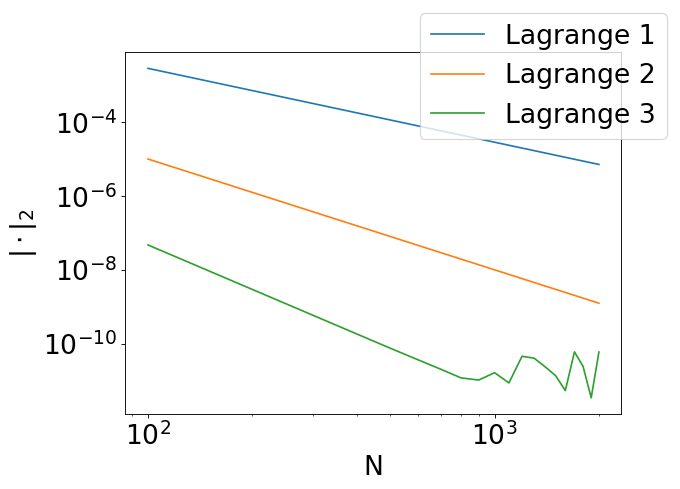

In [27]:
from matplotlib import pyplot

pyplot.figure(figsize=(8, 6), dpi=80)
pyplot.plot(np.arange(100,2100,100,dtype=int),error_L2[:,0],np.arange(100,2100,100,dtype=int),error_L2[:,1],np.arange(100,2100,100,dtype=int),error_L2[:,2])
pyplot.yscale('log')
pyplot.xscale('log')
pyplot.figlegend(["Lagrange 1","Lagrange 2","Lagrange 3"])
pyplot.xlabel('N')
pyplot.ylabel('$\|\cdot\|_2$')
pyplot.rcParams.update({'font.size': 20})
pyplot.savefig('error1D.eps', format='eps')